In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like

from pandas_datareader import data as pdata
import matplotlib.pyplot as plt
import datetime, urllib3,json
import datetime,warnings

%matplotlib inline


import fix_yahoo_finance as yf
yf.pdr_override() # <== that's all it takes :-)

def get_etf_constituents(etf_tickers):
    res={}
    http = urllib3.PoolManager()
    for etf in etf_tickers:
        stock_tickers=[]
        r = http.request('GET', 'https://core-api.barchart.com/v1/EtfConstituents?'+
        'composite=%s&'%etf+
        'fields=symbol,symbolName,percent,sharesHeld,symbolCodes,symbolType,lastPrice,dailyLastPrice&'+
        'orderBy=percent&orderDir=desc&meta=field.shortName,field.type,field.description&page=1&'+
        'limit=100&'+
        'raw=1')
        datas = json.loads(r.data.decode('utf-8'))['data']

        #print("datas ", datas)
        for data in datas:
            if (data['symbol'] != 'Unassigned') and \
                (data['symbol'] != '') and (data['symbol'] != etf):
                stock_tickers.append(data['symbol'])


        res[etf]=stock_tickers
    #print("append etc dict ", res)
    return res


#etfs=['XLF']

def check_all_etfs_corr(etfs, all_stocks_px, corr_thd =[0.9,0.9,0.9]):

    etf_dict =get_etf_constituents(etfs)

    #end_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    #start_date = (end_dt-datetime.timedelta(days=(window*2))).strftime("%Y-%m-%d")
    etf_set={}
    for key, value in etf_dict.items():
        df_sector=[]
        print(key)
        df_sector=pd.DataFrame()
        for symbol in value:
            if symbol in all_stocks_px.columns.values:
                df_sector[symbol]= all_stocks_px[symbol]
        #print("df sector ",df_sector)
        #df = pdata.get_data_yahoo(value, start_date, end_date)

        etf_set[key]=get_high_corr_stocks(df_sector,key, corr_thd)
        #print("etf_ set", etf_set)
    return etf_set

def get_corr_matrix(df, window,price_type='Close'):
    for win in window:
        if df.shape[0]< win:
            warnings.warn(" Increase window size ")
            return

    price_df = df
    dates = price_df.index.values
    symbol =price_df.columns.values
    price =  price_df.as_matrix()
    corr_mtxs={}

    for win in window:
        corr_mtxs[win] = np.corrcoef(price[-win:], rowvar=False) #col is variable

    #print(corr_mtx)
    return dates, symbol, corr_mtxs


def get_high_corr_stocks(df,sector=None, corr_thd = [0.9,0.9,0.8], window=[120,60,20]):

    print ( "===== correlation thd %f====== "%corr_thd[0], corr_thd)
    corr_period={}

    dates, symbols, corr_mtxs = get_corr_matrix(df,window)

    res=set()
    for i in range (len(symbols)):
        for j in range (i+1,len(symbols)):
            #print ("index ", i, j)
            is_corr_stable = True
            for k in range(len(window)):
                #print ("index ", i,symbols[i], j,symbols[j],win, corr_mtxs[win][i,j] )

                #print(type(corr_mtxs[win][i,j]))
                if corr_mtxs[int(window[k])][i,j]<corr_thd[k]:
                    #print ("false  ", i,symbols[i], j,symbols[j], win, corr_mtxs[win][i,j])
                    is_corr_stable = False
                    break
                elif np.isnan(corr_mtxs[int(window[k])][i,j]):
                    is_corr_stable = False
                    break
                    #print ("false  ", i,symbols[i], j,symbols[j], win, corr_mtxs[win][i,j])
                #else:
                  #print ("index ", i,symbols[i], j,symbols[j],win, corr_mtxs[win][i,j] )

        if is_corr_stable:
            res.update([symbols[i],symbols[j]])
            #print ("index ", i,symbols[i], j,symbols[j] )



        #print(res)
        #corr_period[win]=res.copy()

    print("======HIGHLY CORR SET (%s)======"%sector)
    #print(res)
    return list(res)

'''
UTILS
'''
def getOpenCloseDf(stockprice_panel, include_open=False):
    
    result=pd.DataFrame()
    symbols= stockprice_panel.minor_axis
    length = stockprice_panel.shape[1]
    
    for symbol in symbols:
        
        if include_open :
            open_close_px=np.empty([2*length])
            ts=np.empty([2*length])
            open= stockprice_panel.minor_xs(symbol)['Open'].values
            close = stockprice_panel.minor_xs(symbol)['Close'].values
            for i in range (0,len(close)):
                open_close_px[i*2]=open[i]
                open_close_px[i*2+1]=close[i]
                ts[i*2]= int(stockprice_panel.minor_xs(symbol).index[i].timestamp()+9.5*60*60)
                ts[i*2+1]= int(stockprice_panel.minor_xs(symbol).index[i].timestamp()+16*60*60)
            result[symbol]=open_close_px
        else:
            open_close_px=np.empty([length])
            ts=np.empty([length])
            close = stockprice_panel.minor_xs(symbol)['Close'].values
            for i in range (0,len(close)):
                open_close_px[i]=close[i]
                ts[i]= int(stockprice_panel.minor_xs(symbol).index[i].timestamp()+16*60*60)
            result[symbol]=open_close_px
            
        
    result.index=ts

    #print(result)
    return result

'''
UTILS
'''
def plot_price_series(df, ts1, ts2):
    #months = mdates.MonthLocator()  # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, ts1, label=ts1.name,color='b')
    ax.set_ylabel(ts1.name, color='b')
    ax.tick_params('y', colors='b')
    #ax.plot(df.index, ts2, label=ts2.name)
    ax.grid(True)
    
    ax2 = ax.twinx()
    ax2.plot(df.index, ts2, label=ts2.name,color='r')
    ax2.set_ylabel(ts2.name, color='r')
    ax2.tick_params('y', colors='r')
    
    fig.autofmt_xdate()

    plt.xlabel('Day')
    #plt.ylabel('Price ($)')
    plt.title('%s and %s Daily Prices' % (ts1.name, ts2.name))
    #plt.legend()
    plt.show()


import statsmodels.tsa.stattools as st
import statsmodels.api as sm
#result = ts.coint(ts1, ts2)

#print ("coin test - sig lvl 5%", result)


def coint_finder(all_stck_df, coint_thd=0.01):
    stck_size = len(all_stck_df.columns)
    print("stock size ",stck_size, len(all_stck_df))
    pairs=[[]]
    signal_count =0
    for i in range (0,stck_size):
        for j in range (i+1, stck_size):
            ts1 = all_stck_df[ list(all_stck_df)[i]]
            ts2 = all_stck_df[ list(all_stck_df)[j]]

            coin_test = st.coint(ts1, ts2)
            #print(coin_test)
            if ( coin_test[1]< coint_thd ): #pvalue,  If the pvalue is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship.

                print("coin_test %s and %s "%(ts1.name, ts2.name),coin_test)

                x=ts2
                y=ts1
                x=sm.add_constant(x)
                res = sm.OLS(y,x).fit()
                print ("correlation ")
                for k in [120, 60 ,20]:
                    if len(ts1)<k:
                        continue
                    corr = np.corrcoef(ts1.tail(k), ts2.tail(k))
                    print ("(%i):"%k, corr[0][1])

                print("OLS: ", res.params)

                base_url= "https://www.tradingview.com/chart/?symbol="
                print("check chart: https://www.tradingview.com/chart/?symbol=%s-(1*%s)*%s"%(ts1.name,res.params[1],ts2.name))

                fig, ax = plt.subplots()
                ax.plot(ts1.index,ts1-res.params[1]*ts2,label=ts1.name+"-"+ts2.name)
                ax.grid(True)
                fig.autofmt_xdate()
                plt.legend()
                plt.show()

                plot_price_series(all_stck_df,ts1,ts2)

                pairs.append([ts1.name, ts2.name])
                print("===============")

                signal_count+=1
            else:
                pass
    print("Signal count ", signal_count)

In [5]:
#rolling standerdize error

def get_rolling_stdize_error():
    pass

SyntaxError: invalid syntax (<ipython-input-5-0800abd350be>, line 3)

In [6]:
#MAIN 

def __main__(etfs, hist_win, check_win,
             end_date=datetime.date.today().strftime("%Y-%m-%d"),
             include_open=False,  corr_thd = [0.9,0.9,0.9],coint_thd=0.01):

    #end_date=datetime.date.today().strftime("%Y-%m-%d")
    end_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    start_date = (end_dt-datetime.timedelta(days=(hist_win*2))).strftime("%Y-%m-%d")

    stockprice=None

    symbol=[]
    for etf in etfs:
        symbol.extend(get_etf_constituents([etf])[etf])

    stockprice = pdata.get_data_yahoo(symbol, start_date, end_date)
    print(stockprice.shape)
    
    normalized_px = stockprice['Close']
    
    if include_open:
        check_win *=2
        normalized_px=getOpenCloseDf(stockprice,True)
    #else 
        #normalized_px = getOpenCloseDf(stockprice,False)

    high_corr = check_all_etfs_corr(etfs,normalized_px, corr_thd)

    df_sector=pd.DataFrame()
    for key, value in high_corr.items():
        df_sector = pd.DataFrame(normalized_px, columns=value)
        for symbol in value:
            if symbol in normalized_px.columns.values:
                df_sector[symbol]= normalized_px[symbol]
        print("-----SECTOR %s-----"%key)
        df_sector= df_sector.tail(-check_win)
        coint_finder(df_sector,coint_thd) # use raw price to do cointergation and regression
        
        
#RUN
etfs=['XLF','XLE','XLI','XLB','XLP','XLY','XTL','XLK','XLV','XLU','XLRE']

#__main__(['XLF'],hist_win =300,check_win=120,
         
#         include_open=True,
#         corr_thd = [0.5,0.5,0.5],coint_thd=0.01 )

NameError: name 'datetime' is not defined

In [7]:
window=300
etfs=['XLF','XLE','XLI','XLB','XLP','XLY','XTL','XLK','XLV','XLU','XLRE']
etfs=['XLF']

end_date=datetime.date.today().strftime("%Y-%m-%d")
end_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d')
start_date = (end_dt-datetime.timedelta(days=(window*2))).strftime("%Y-%m-%d")


stockprice=None

symbol=[]
for etf in etfs:
    symbol.extend(get_etf_constituents([etf])[etf])

stockprice = pdata.get_data_yahoo(symbol, start_date, end_date)
print(stockprice.shape)
#stockprice=stockprice['Close']

NameError: name 'datetime' is not defined

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:42: ResourceWarning: unclosed <ssl.SSLSocket fd=56, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.0.1.12', 55175), raddr=('54.210.154.59', 443)>


XLF
===== correlation thd 0.000000======  [0.0, 0.0, 0.0]
======HIGHLY CORR SET (XLF)======
-----SECTOR XLF-----
stock size  44 300
coin_test CFG and DFS  (-3.6952851863139515, 0.018582700549471077, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.854491243419
(60): 0.825451899797
(20): 0.749501774158
OLS:  const    1.405627
DFS      0.551486
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=CFG-(1*0.551486046776)*DFS


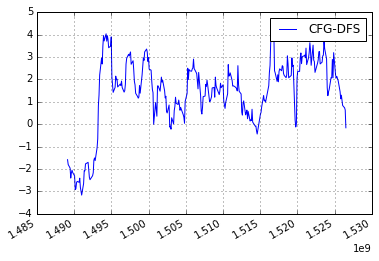

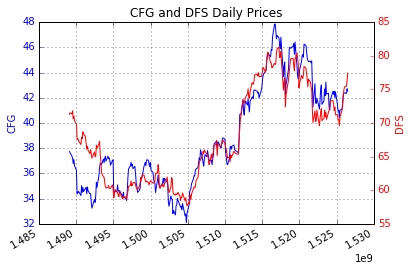

coin_test CFG and HBAN  (-3.5865271507282577, 0.025457732532946961, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.934348017675
(60): 0.948198556857
(20): 0.859173054784
OLS:  const   -11.043122
HBAN      3.552181
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=CFG-(1*3.55218125145)*HBAN


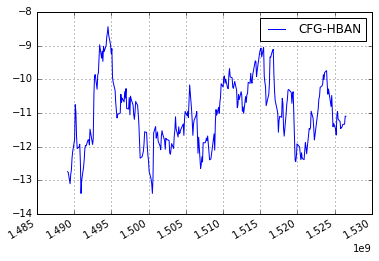

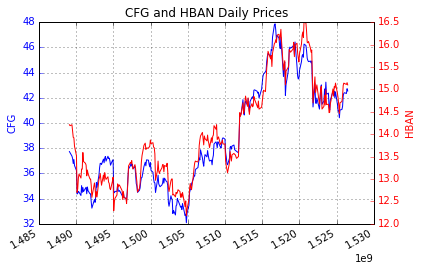

coin_test CFG and PBCT  (-3.4175575793857451, 0.040437449926988132, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.881271745862
(60): 0.958490416419
(20): 0.642888256499
OLS:  const   -34.592642
PBCT      4.032959
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=CFG-(1*4.0329587038)*PBCT


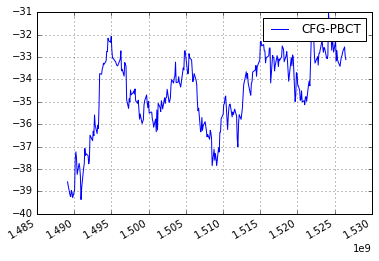

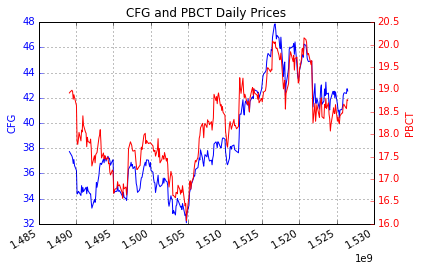

coin_test CMA and NTRS  (-3.7070335814235342, 0.017947349004075373, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.878894854804
(60): 0.625480247832
(20): 0.777365110233
OLS:  const   -60.748154
NTRS      1.476212
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=CMA-(1*1.47621226508)*NTRS


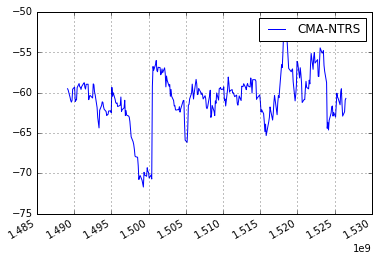

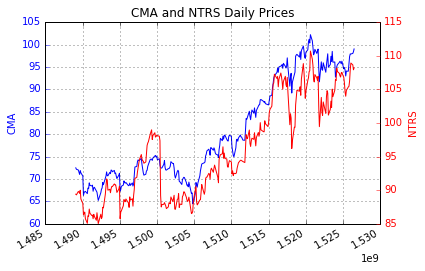

coin_test CMA and RF  (-3.6444533551437805, 0.021563326641312365, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.966339880356
(60): 0.910885926234
(20): 0.868539675034
OLS:  const   -4.697897
RF       5.303487
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=CMA-(1*5.30348676407)*RF


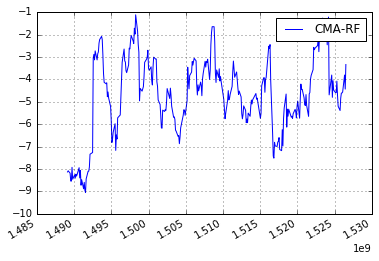

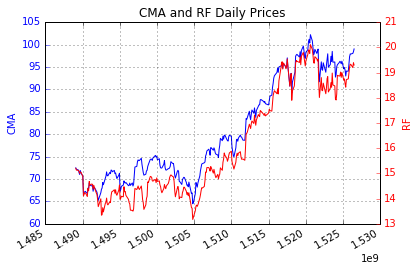

coin_test TROW and RJF  (-3.3764688187971994, 0.045032111262576446, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.814217657872
(60): 0.827101929977
(20): 0.966320253942
OLS:  const   -95.797373
RJF       2.228949
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=TROW-(1*2.22894890326)*RJF


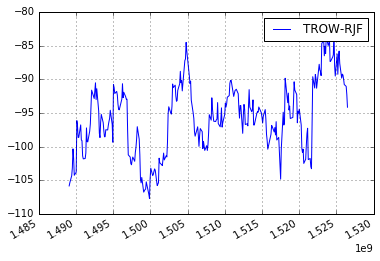

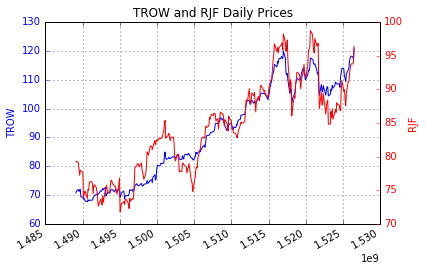

coin_test FITB and CME  (-3.5105538772348632, 0.031471208904619269, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.72882131186
(60): 0.255056861232
(20): -0.396831417544
OLS:  const    3.276924
CME      0.182622
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=FITB-(1*0.182622007016)*CME


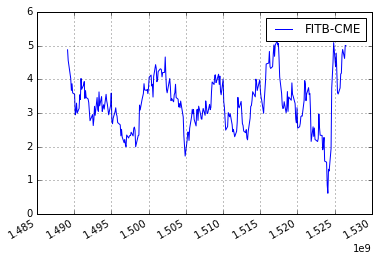

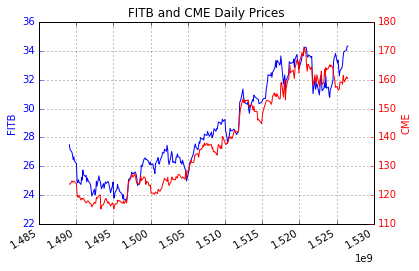

coin_test SCHW and NTRS  (-3.3670402227943441, 0.046145443908848838, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.849284884772
(60): 0.758696039473
(20): 0.346984803918
OLS:  const   -30.273548
NTRS      0.799321
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=SCHW-(1*0.799320558598)*NTRS


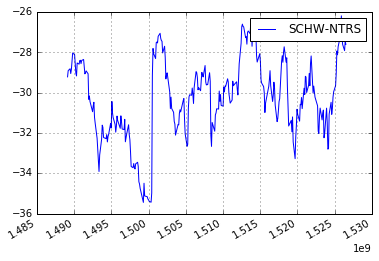

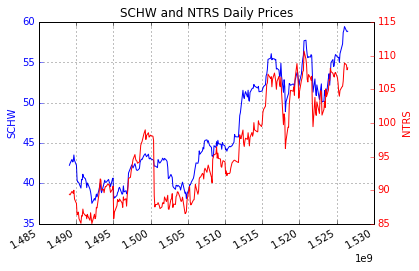

coin_test AFL and RJF  (-3.8798578106179611, 0.010572606866719545, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.385542020964
(60): 0.456784844565
(20): 0.0739208713875
OLS:  const    8.840177
RJF      0.385714
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=AFL-(1*0.38571374984)*RJF


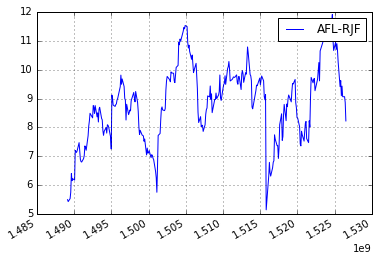

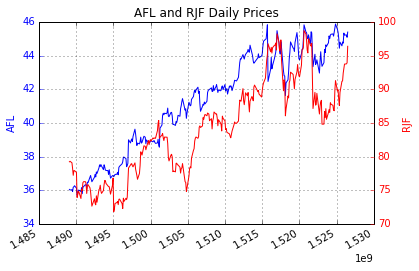

coin_test MTB and NTRS  (-4.0357643614585701, 0.0063814722209430512, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.785299624661
(60): 0.47821965712
(20): 0.724426066755
OLS:  const    7.898455
NTRS     1.672703
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=MTB-(1*1.67270333941)*NTRS


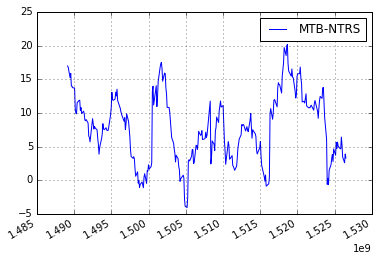

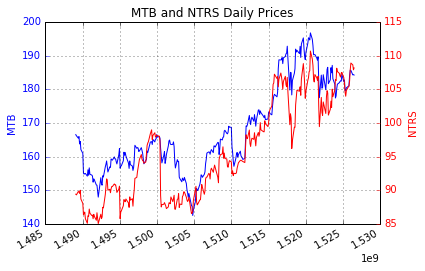

coin_test RJF and MCO  (-3.8250644113945036, 0.012547839918368178, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.444565509506
(60): 0.717717166306
(20): 0.878165197244
OLS:  const    37.198302
MCO       0.334093
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=RJF-(1*0.334093087211)*MCO


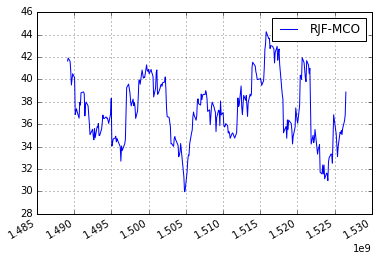

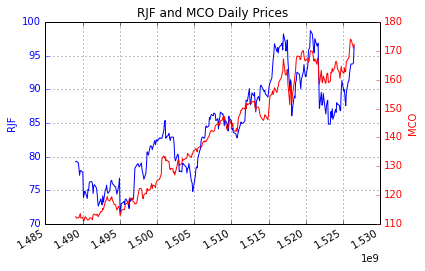

coin_test RJF and BLK  (-4.2130888501996351, 0.0034846746235124211, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.84115544833
(60): 0.823341294998
(20): 0.850495331489
OLS:  const    33.808884
BLK       0.107780
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=RJF-(1*0.107780435393)*BLK


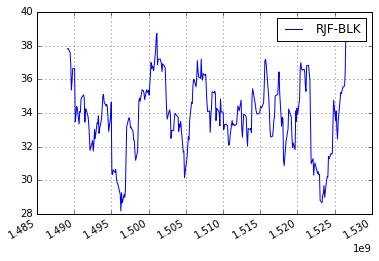

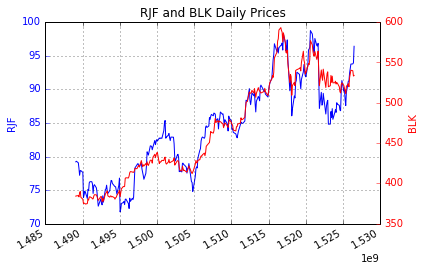

coin_test RJF and JPM  (-3.6554441310619872, 0.020885835964205055, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.727194502902
(60): 0.757521992722
(20): 0.670021028785
OLS:  const    22.453363
JPM       0.622465
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=RJF-(1*0.622464510778)*JPM


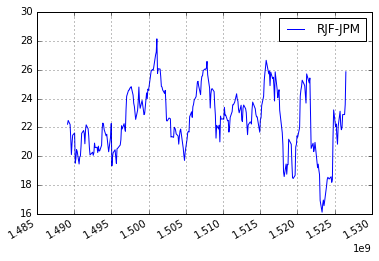

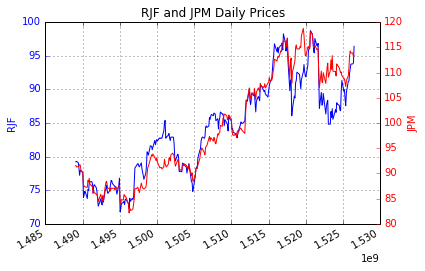

coin_test RJF and MS  (-4.1046714419299244, 0.0050638760839761439, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.841376178901
(60): 0.818083343486
(20): 0.573792887425
OLS:  const    14.846058
MS        1.412084
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=RJF-(1*1.41208434592)*MS


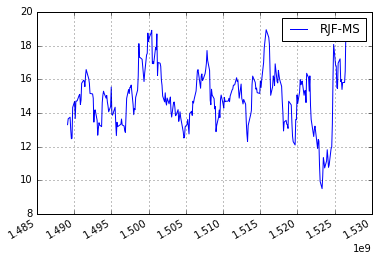

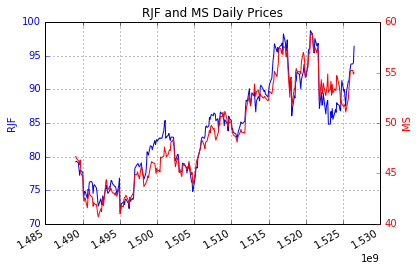

coin_test RJF and CME  (-3.7838180408859863, 0.014244098488266559, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.282560988325
(60): 0.512169388016
(20): -0.154978470128
OLS:  const    33.475804
CME       0.365443
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=RJF-(1*0.365442900858)*CME


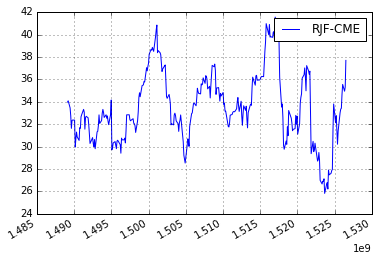

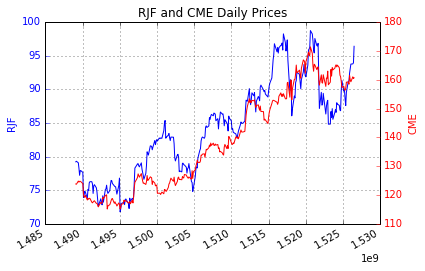

coin_test ZION and BBT  (-3.3995488655952273, 0.042400601929928949, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.91761553667
(60): 0.901846234956
(20): 0.934908644872
OLS:  const   -12.933148
BBT       1.249270
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=ZION-(1*1.24926951362)*BBT


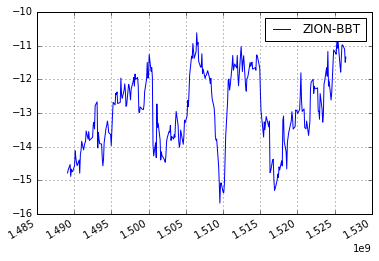

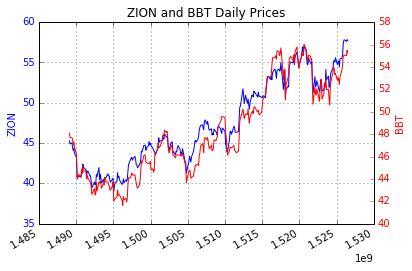

coin_test HBAN and STI  (-3.7700651462890797, 0.014853105285422843, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.914336833339
(60): 0.956240348879
(20): 0.815356982786
OLS:  const    2.695749
STI      0.185440
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=HBAN-(1*0.185439740177)*STI


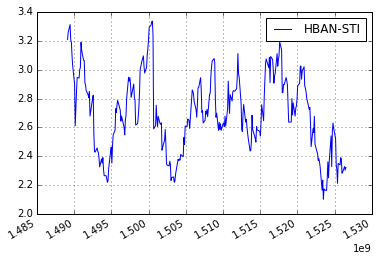

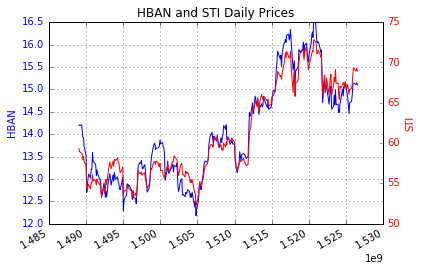

coin_test HBAN and BAC  (-3.5035194667134033, 0.032084668251350652, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.953906320988
(60): 0.945726082479
(20): 0.824845055543
OLS:  const    5.203560
BAC      0.328538
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=HBAN-(1*0.32853836759)*BAC


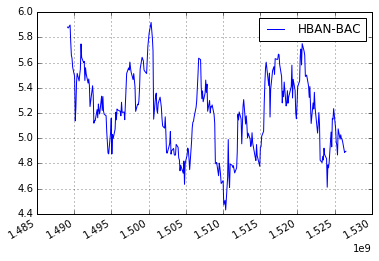

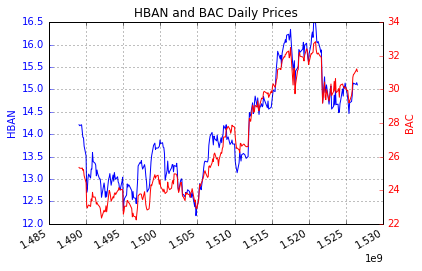

coin_test PNC and BLK  (-3.3630003729670488, 0.046629398665879916, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.847183190526
(60): 0.903021505681
(20): 0.852518040841
OLS:  const    38.673154
BLK       0.208693
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=PNC-(1*0.208693219743)*BLK


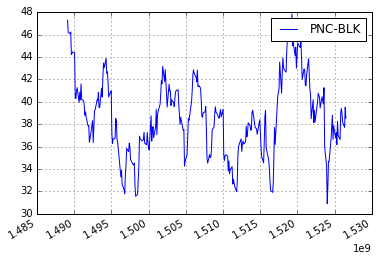

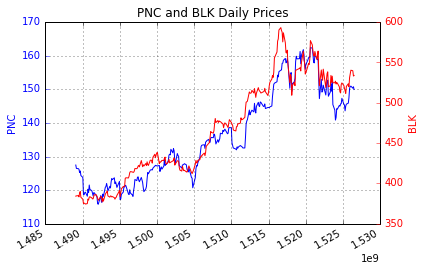

coin_test BLK and MS  (-3.7441916966042341, 0.016061303939061633, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.920386624791
(60): 0.94531977911
(20): 0.810729481747
OLS:  const   -148.897542
MS        12.550016
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=BLK-(1*12.5500155851)*MS


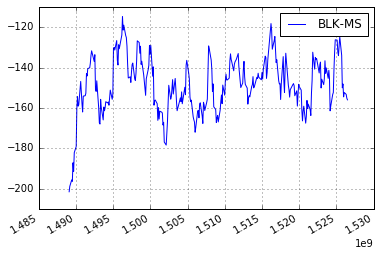

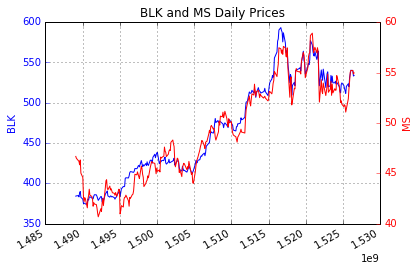

coin_test STI and RF  (-3.9901719172003549, 0.0074164137031547785, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.946109718153
(60): 0.928741292704
(20): 0.862702359555
OLS:  const    16.876626
RF        2.750279
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=STI-(1*2.75027879864)*RF


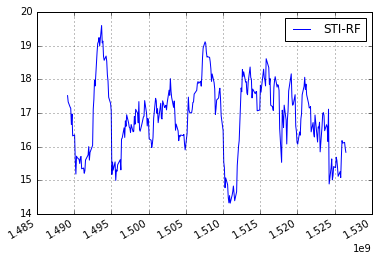

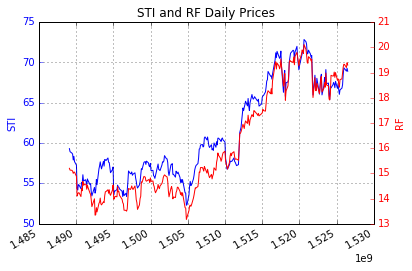

coin_test NTRS and RF  (-4.1058115107578237, 0.0050443286234200888, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.852247034933
(60): 0.665531507847
(20): 0.519092925459
OLS:  const    43.741421
RF        3.233560
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=NTRS-(1*3.23355961804)*RF


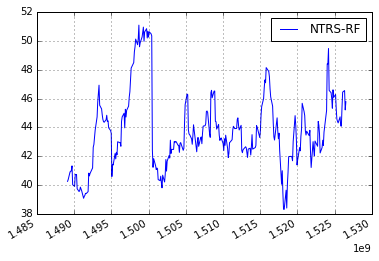

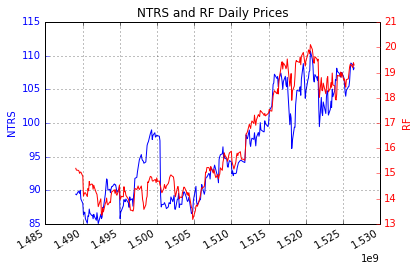

coin_test JPM and MS  (-3.4108009767892287, 0.04116489815148465, array([-3.93344345, -3.35664144, -3.05866504]))
correlation 
(120): 0.904749076622
(60): 0.908447958632
(20): 0.954793346437
OLS:  const   -7.728816
MS       2.176922
dtype: float64
check chart: https://www.tradingview.com/chart/?symbol=JPM-(1*2.17692167768)*MS


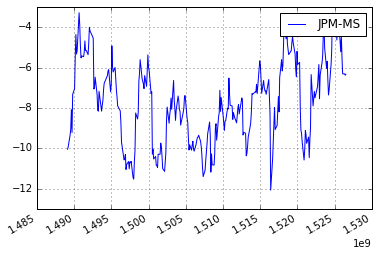

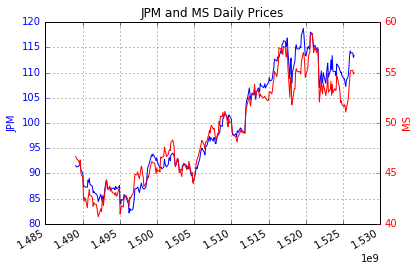

Signal count  23


In [6]:
# MAIN - generate plot 

#SET-UP
include_open = False
window =300
corr_thd = [0.0,0.0,0.0]
coint_thd=0.05

#RUN
normalized_px = getOpenCloseDf(stockprice)
if include_open:
    window *=2
    normalized_px=getOpenCloseDf(stockprice,True)

high_corr = check_all_etfs_corr(etfs,normalized_px, corr_thd)

df_sector=pd.DataFrame()
for key, value in high_corr.items():
    df_sector = pd.DataFrame(normalized_px, columns=value)
    for symbol in value:
        if symbol in normalized_px.columns.values:
            df_sector[symbol]= normalized_px[symbol]
    print("-----SECTOR %s-----"%key)
    df_sector= df_sector.tail(window)
    coint_finder(df_sector,coint_thd) # use raw price to do cointergation and regression